In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import optuna

# ✅ Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [2]:
""" MODEL STUFF """

# Define LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=2, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        return self.fc(lstm_out[:, -1, :])  # Last time step output


# Helper: Create sequences for LSTM
def create_sequences(data, dates, seq_len=30):
    X, y, y_dates = [], [], []
    data_array = data  # Already a NumPy array
    for i in range(len(data_array) - seq_len):
        X.append(data_array[i:i+seq_len])
        y.append(data_array[i+seq_len, 0])
        y_dates.append(dates[i+seq_len])
    return np.array(X), np.array(y), np.array(y_dates)

# Helper: Inverse scale predictions for VN-30 (first column)
def inverse_scale_predictions(predictions, scaler):
    num_features = scaler.min_.shape[0]
    dummy = np.zeros((predictions.shape[0], num_features))
    dummy[:, 0] = predictions.flatten()
    return scaler.inverse_transform(dummy)[:, 0]


# Training function only, returns both the model and the overall average training loss across all epochs
def train_model(params, X_train_tensor, y_train_tensor, epochs=20):
    model = LSTMModel(
        input_size=X_train_tensor.shape[2],
        hidden_size=params['hidden_size'],
        num_layers=params['num_layers'],
        dropout=params['dropout']
    ).to(device)
    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])
    criterion = nn.MSELoss()
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)

    epoch_losses = []
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            loss = criterion(model(batch_X), batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        avg_loss = epoch_loss / len(train_loader)
        epoch_losses.append(avg_loss)
    overall_avg_loss = np.mean(epoch_losses)
    return model, overall_avg_loss


# Evaluation function (used after tuning)
def evaluate_model(model, test_loader, criterion):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            val_loss += criterion(model(batch_X), batch_y).item()
    return val_loss / len(test_loader)


# Optuna objective: returns the overall average training loss and stores the trained model
def objective(trial, X_train_tensor, y_train_tensor):
    params = {
        'hidden_size': trial.suggest_categorical('hidden_size', [64, 128, 256]),
        'num_layers': trial.suggest_int('num_layers', 1, 3),
        'dropout': trial.suggest_float('dropout', 0.1, 0.5),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True),
        'batch_size': trial.suggest_categorical('batch_size', [32, 64, 128])
    }
    model, overall_avg_loss = train_model(params, X_train_tensor, y_train_tensor, epochs=50)
    trial.set_user_attr("model", model)
    return overall_avg_loss


# Main pipeline
def lstm_model_pipeline(data, seq_len=30, tuning=True, best_params={'hidden_size': 128, 'num_layers': 2,
    'dropout': 0.3, 'learning_rate': 1e-4, 'batch_size': 32}):

    if isinstance(data, pd.Series):
        data = data.to_frame()

    train_size = int(0.9 * len(data))
    scaler = MinMaxScaler()
    scaler.fit(data[:train_size])
    data_scaled = scaler.transform(data)

    X, y, y_dates = create_sequences(data_scaled, data.index, seq_len)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    y_dates_train, y_dates_test = y_dates[:train_size], y_dates[train_size:]

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1).to(device)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1).to(device)

    if tuning:
        study = optuna.create_study(direction='minimize')
        study.optimize(lambda trial: objective(trial, X_train_tensor, y_train_tensor), n_trials=10)
        best_params = study.best_params
        print("Best Hyperparameters:", best_params)
        print(f"Best Overall Average Training Loss: {study.best_value:.4f}")
        final_model = study.best_trial.user_attrs["model"]
    else:
        final_model, overall_avg_loss = train_model(best_params, X_train_tensor, y_train_tensor, epochs=50)
        print(f"Overall Average Training Loss: {overall_avg_loss:.4f}")

    criterion = nn.MSELoss()
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    test_loader = DataLoader(test_dataset, batch_size=best_params['batch_size'], shuffle=False)

    val_loss = evaluate_model(final_model, test_loader, criterion)
    print(f"Final Evaluation Loss on Test Set: {val_loss:.4f}")

    final_model.eval()
    with torch.no_grad():
        y_pred_tensor = final_model(X_test_tensor).cpu().numpy()
        y_true_tensor = y_test_tensor.cpu().numpy()

    y_pred = inverse_scale_predictions(y_pred_tensor, scaler)
    y_true = inverse_scale_predictions(y_true_tensor, scaler)

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    if len(y_true) > 1:
        directional_accuracy = np.mean(np.sign(np.diff(y_true)) == np.sign(np.diff(y_pred)))
    else:
        directional_accuracy = np.nan

    print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}, Directional Accuracy: {directional_accuracy:.4f}")

    plt.figure(figsize=(12,6))
    plt.plot(y_dates_test, y_true, label="Actual VN-30", marker='o', color="blue")
    plt.plot(y_dates_test, y_pred, label="Predicted VN-30", marker='s', linestyle="dashed", color="red")
    plt.xlabel("Date")
    plt.ylabel("VN-30")
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.title("LSTM Predictions vs. Actual VN-30")
    plt.show()

    results_df = pd.DataFrame({
        "Date": y_dates_test,
        "Actual VN-30": y_true,
        "Predicted VN-30": y_pred
    })
    print("Predicted vs. Actual VN-30 (Test Set):")
    print(results_df)

    data_for_prediction = np.array(data_scaled[-30:])
    return final_model, torch.tensor(data_for_prediction, dtype=torch.float32).to(device), scaler, y_pred


# Future Prediction Function
def future_prediction(X_test, y_pred, data, scaler, model, num_days=30):
    if isinstance(data, pd.Series):
        data = data.to_frame()

    model.eval()
    input_seq = X_test.cpu().numpy()
    future_preds = []
    for _ in range(num_days):
        input_tensor = torch.tensor(input_seq, dtype=torch.float32).unsqueeze(0).to(device)
        with torch.no_grad():
            pred = model(input_tensor).cpu().numpy()[0, 0]
        future_preds.append(pred)
        input_seq = np.roll(input_seq, -1, axis=0)
        input_seq[-1, 0] = pred

    future_preds = inverse_scale_predictions(np.array(future_preds).reshape(-1,1), scaler)
    last_date = data.index[-1]
    future_dates = []
    while len(future_dates) < num_days:
        last_date += pd.Timedelta(days=1)
        if last_date.weekday() < 5:
            future_dates.append(last_date)

    plt.figure(figsize=(12,6))
    plt.plot(future_dates, future_preds, marker='o', linestyle="dashed", color="red", label="Predicted VN-30")
    plt.xlabel("Date")
    plt.ylabel("VN-30")
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.title(f"Predicted VN-30 for Next {num_days} Trading Days")
    plt.show()

    historical_dates = data.index[-100:]
    historical_values = data.iloc[-100:, 0].values
    plt.figure(figsize=(12,6))
    plt.plot(historical_dates, historical_values, label="Historical VN-30", color="blue")
    plt.plot(historical_dates, y_pred[-100:], label="Test Predictions", color="red")
    plt.plot(future_dates, future_preds, color="green", label="Future Predicted VN-30")
    plt.xlabel("Date")
    plt.ylabel("VN-30")
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.title("Historical VN-30 with Future Predictions")
    plt.show()

    future_df = pd.DataFrame({"Date": future_dates, "Predicted VN-30": future_preds})
    print(future_df)

In [3]:
# =============================================================================
# FEATURE ENGINEERING FUNCTIONS
# =============================================================================

def compute_RSI(series, window=14):
    """
    Compute the Relative Strength Index (RSI) for a time-series.
    
    Args:
        series (pd.Series): Series of prices.
        window (int): Window size.
    
    Returns:
        pd.Series: RSI values.
    """
    delta = series.diff(1)
    gain = delta.where(delta > 0, 0).rolling(window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window).mean()
    RS = gain / loss
    return 100 - (100 / (1 + RS))


def lag_features_indicators(df, numerical_columns):
    """
    Generate lag features, moving averages, RSI, MACD, volatility, seasonality,
    and interaction features.
    
    Args:
        df (pd.DataFrame): Input data.
        numerical_columns (list): List of numerical column names.
    
    Returns:
        pd.DataFrame: DataFrame with additional features.
    """
    copy_df = df.copy()
    # Lagged Features
    lag_days = [1, 2, 3, 5, 10]
    for col in numerical_columns:
        for lag in lag_days:
            copy_df[f'{col}_Lag{lag}'] = copy_df[col].shift(lag)
    
    # Moving Averages and Exponential Moving Averages
    for col in numerical_columns:
        copy_df[f'{col}_SMA_10'] = copy_df[col].rolling(window=10).mean()
        copy_df[f'{col}_SMA_20'] = copy_df[col].rolling(window=20).mean()
        copy_df[f'{col}_EMA_10'] = copy_df[col].ewm(span=10, adjust=False).mean()
        copy_df[f'{col}_EMA_20'] = copy_df[col].ewm(span=20, adjust=False).mean()
    
    # Relative Strength Index (RSI)
    for col in numerical_columns:
        copy_df[f'{col}_RSI_14'] = compute_RSI(copy_df[col])
    
    # Moving Average Convergence Divergence (MACD)
    for col in numerical_columns:
        copy_df[f'{col}_EMA_12'] = copy_df[col].ewm(span=12, adjust=False).mean()
        copy_df[f'{col}_EMA_26'] = copy_df[col].ewm(span=26, adjust=False).mean()
        copy_df[f'{col}_MACD'] = copy_df[f'{col}_EMA_12'] - copy_df[f'{col}_EMA_26']
    
    # Additional Feature: Rolling Standard Deviation for Volatility
    for col in numerical_columns:
        copy_df[f'{col}_RollingStd_10'] = copy_df[col].rolling(window=10).std()
    
    # Seasonality Features: Day of Week and Month
    copy_df['DayOfWeek'] = copy_df.index.dayofweek
    copy_df['Month'] = copy_df.index.month
    
    # Interaction Feature: Ratio of EMA_10 to EMA_20
    for col in numerical_columns:
        copy_df[f'{col}_EMA_Ratio'] = copy_df[f'{col}_EMA_10'] / copy_df[f'{col}_EMA_20']
    
    # Drop NA values caused by shifting and rolling
    copy_df.dropna(inplace=True)
    
    return copy_df


def quicky_data(df):
    """
    Preprocess the data by converting the 'Date' column to datetime,
    setting it as index, and dropping unnecessary columns.
    
    Args:
        df (pd.DataFrame): Raw data.
    
    Returns:
        pd.DataFrame: Preprocessed data.
    """
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    
    if 'Index' in df.columns:
        df.drop(columns=['Index'], inplace=True)
    
    return df

def select_features_by_correlation(df, target_col="VN_30_Close", train_ratio=0.9, corr_threshold=0.05):
    """
    Splits the DataFrame by time (first train_ratio% of rows is 'training'),
    calculates correlation of each feature with the target on TRAIN rows only,
    and returns the subset of columns (target + selected features).
    
    Args:
        df (pd.DataFrame): Full dataset (includes the target column).
        target_col (str): Target column name, default = "VN_30_Close".
        train_ratio (float): Proportion of data used for 'training'.
        corr_threshold (float): Minimum absolute correlation needed to keep a feature.
    
    Returns:
        pd.DataFrame: A filtered DataFrame with only 'target_col' + selected features.
    """
    # Sort by index if needed (assuming your index is Date or similar)
    df = df.sort_index()
    n_train = int(len(df) * train_ratio)
    
    # TRAIN portion (first 90% by default)
    df_train = df.iloc[:n_train]
    
    # Identify all potential features (exclude the target itself)
    all_features = [col for col in df.columns if col != target_col]
    
    # Calculate absolute correlation with the target on the training portion only
    corr_series = df_train[all_features].corrwith(df_train[target_col]).abs()
    
    # Filter by threshold
    selected_features = corr_series[corr_series >= corr_threshold].index.tolist()
    
    print(f"Features with abs(corr) >= {corr_threshold}:")
    print(selected_features)
    
    # Return only target + selected features
    return df[[target_col] + selected_features]

In [4]:
# 📂 Load dataset
file_path_1 = "../ready_data/cleaned_vn_30_data.csv"
df_1 = pd.read_csv(file_path_1)
df_1 = quicky_data(df_1)

[I 2025-04-10 16:53:53,795] A new study created in memory with name: no-name-268d0761-c79e-4f90-8418-dca03a395aec
[I 2025-04-10 16:57:15,619] Trial 0 finished with value: 0.0009915983351788276 and parameters: {'hidden_size': 256, 'num_layers': 3, 'dropout': 0.25557515845857565, 'learning_rate': 0.00108113254512192, 'batch_size': 64}. Best is trial 0 with value: 0.0009915983351788276.
/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3199071997771843 and num_layers=1
  warnings.warn(
[I 2025-04-10 16:57:27,929] Trial 1 finished with value: 0.020117750067476424 and parameters: {'hidden_size': 64, 'num_layers': 1, 'dropout': 0.3199071997771843, 'learning_rate': 0.0001529107924958231, 'batch_size': 128}. Best is trial 0 with value: 0.0009915983351788276.
[I 2025-04-10 16:58:38,560] Trial 2 finished with value: 0.0008054

Best Hyperparameters: {'hidden_size': 64, 'num_layers': 3, 'dropout': 0.3798261586028116, 'learning_rate': 0.003724699823453465, 'batch_size': 32}
Best Overall Average Training Loss: 0.0008
Final Evaluation Loss on Test Set: 0.0040
RMSE: 52.6530, MAE: 48.6409, R²: -0.5125, Directional Accuracy: 0.5329


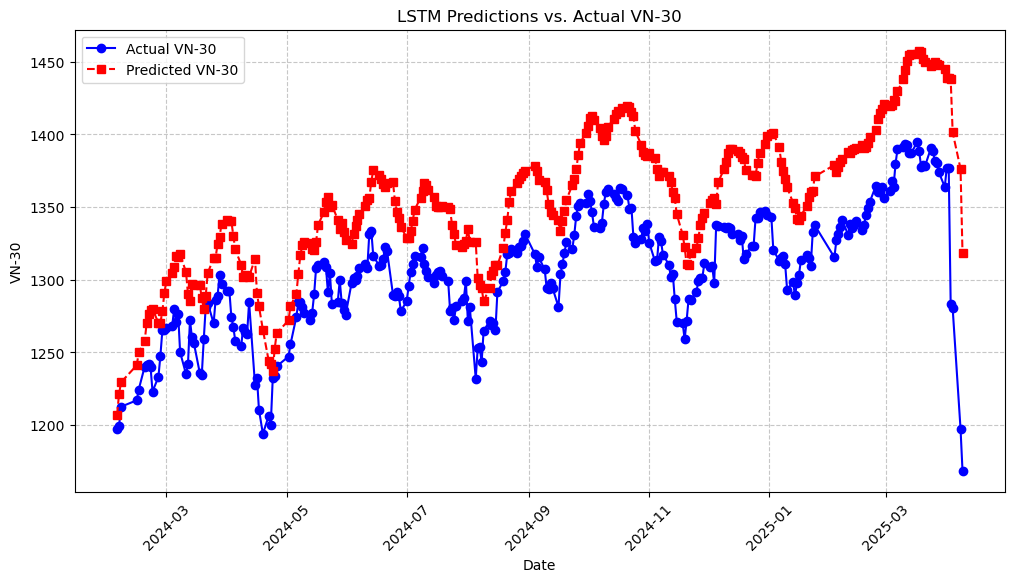

Predicted vs. Actual VN-30 (Test Set):
          Date  Actual VN-30  Predicted VN-30
0   2024-02-05   1197.360027      1207.172516
1   2024-02-06   1199.170014      1221.137257
2   2024-02-07   1212.700021      1229.477489
3   2024-02-15   1217.120030      1241.237282
4   2024-02-16   1224.540033      1250.074805
..         ...           ...              ...
285 2025-04-02   1376.940003      1438.633127
286 2025-04-03   1283.179975      1438.239851
287 2025-04-04   1280.520002      1401.425792
288 2025-04-08   1197.510016      1376.379413
289 2025-04-09   1168.679989      1318.317453

[290 rows x 3 columns]


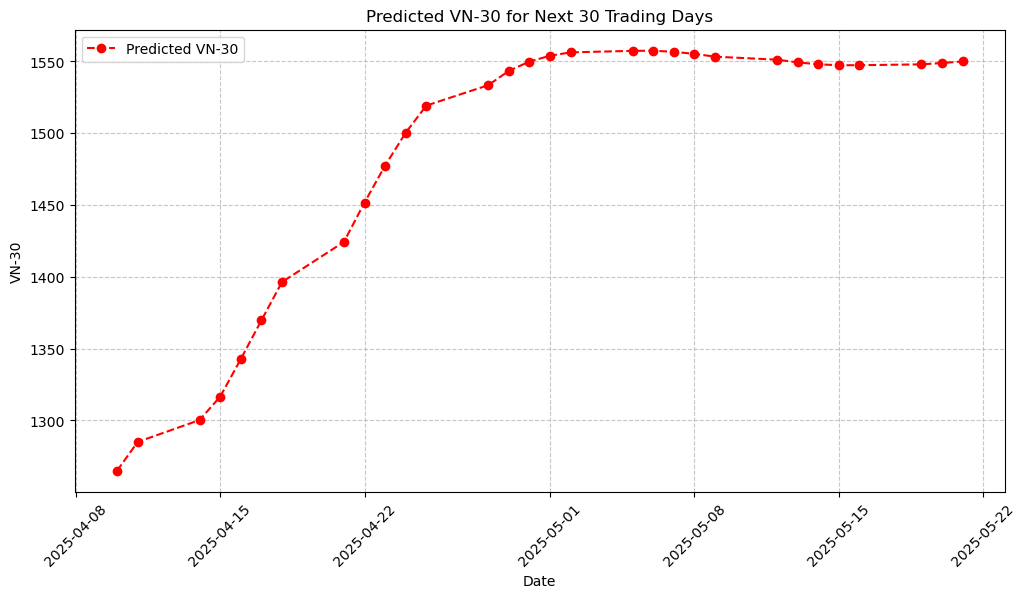

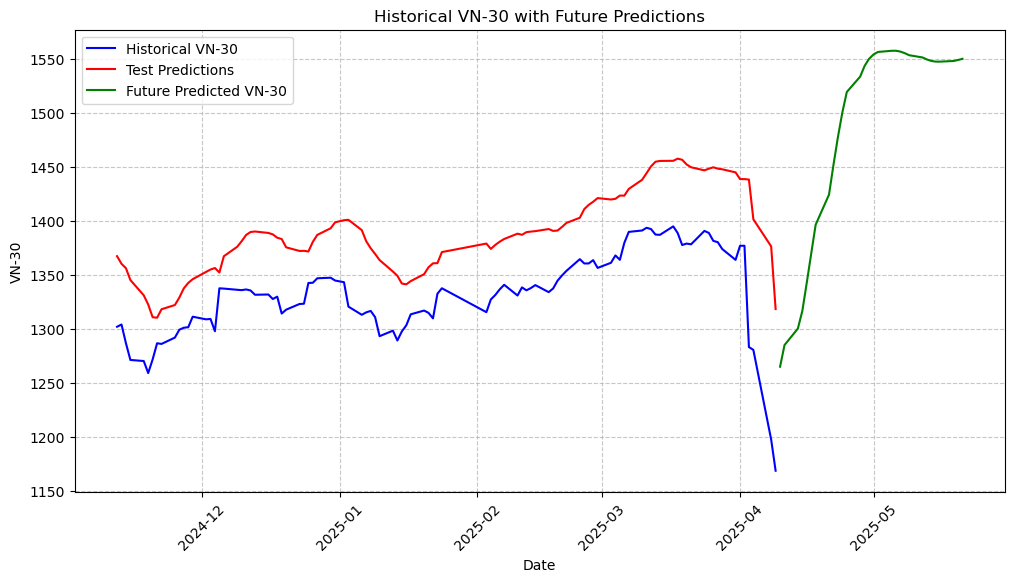

         Date  Predicted VN-30
0  2025-04-10      1264.976223
1  2025-04-11      1285.023263
2  2025-04-14      1300.253849
3  2025-04-15      1316.523645
4  2025-04-16      1342.712237
5  2025-04-17      1369.679764
6  2025-04-18      1396.406296
7  2025-04-21      1424.305444
8  2025-04-22      1451.749298
9  2025-04-23      1477.492572
10 2025-04-24      1500.448669
11 2025-04-25      1519.301522
12 2025-04-28      1533.502741
13 2025-04-29      1543.434953
14 2025-04-30      1549.960748
15 2025-05-01      1554.015254
16 2025-05-02      1556.341071
17 2025-05-05      1557.411289
18 2025-05-06      1557.491103
19 2025-05-07      1556.734482
20 2025-05-08      1555.282717
21 2025-05-09      1553.351255
22 2025-05-12      1551.260299
23 2025-05-13      1549.383642
24 2025-05-14      1548.035690
25 2025-05-15      1547.380927
26 2025-05-16      1547.406475
27 2025-05-19      1547.988031
28 2025-05-20      1548.921809
29 2025-05-21      1550.010093


In [5]:
# 📊 Select only VN-30 for prediction
data = df_1["VN_30_Close"]

# 🚀 Train the model and get the test set
model, X_test_tensor, scaler, y_pred = lstm_model_pipeline(data)

# 🔮 Generate future predictions
future_prediction(X_test_tensor, y_pred, data, scaler, model, num_days=30)

[I 2025-04-10 17:02:25,858] A new study created in memory with name: no-name-a8032356-71b0-46c9-93fe-843ed7f44314
[I 2025-04-10 17:04:26,010] Trial 0 finished with value: 0.0014763753129923515 and parameters: {'hidden_size': 256, 'num_layers': 2, 'dropout': 0.40195482945539457, 'learning_rate': 0.0027181460176211, 'batch_size': 128}. Best is trial 0 with value: 0.0014763753129923515.
[I 2025-04-10 17:05:38,174] Trial 1 finished with value: 0.002736551411750649 and parameters: {'hidden_size': 64, 'num_layers': 3, 'dropout': 0.3848004301347974, 'learning_rate': 0.00014454812395205265, 'batch_size': 32}. Best is trial 0 with value: 0.0014763753129923515.
[I 2025-04-10 17:06:17,586] Trial 2 finished with value: 0.002388541690382661 and parameters: {'hidden_size': 64, 'num_layers': 3, 'dropout': 0.4136540846292557, 'learning_rate': 0.0012714634657469315, 'batch_size': 128}. Best is trial 0 with value: 0.0014763753129923515.
/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/rnn.py

Best Hyperparameters: {'hidden_size': 128, 'num_layers': 1, 'dropout': 0.3998143055678183, 'learning_rate': 0.0017384382693525816, 'batch_size': 64}
Best Overall Average Training Loss: 0.0006
Final Evaluation Loss on Test Set: 0.0008
RMSE: 30.4662, MAE: 20.0985, R²: 0.4936, Directional Accuracy: 0.5260


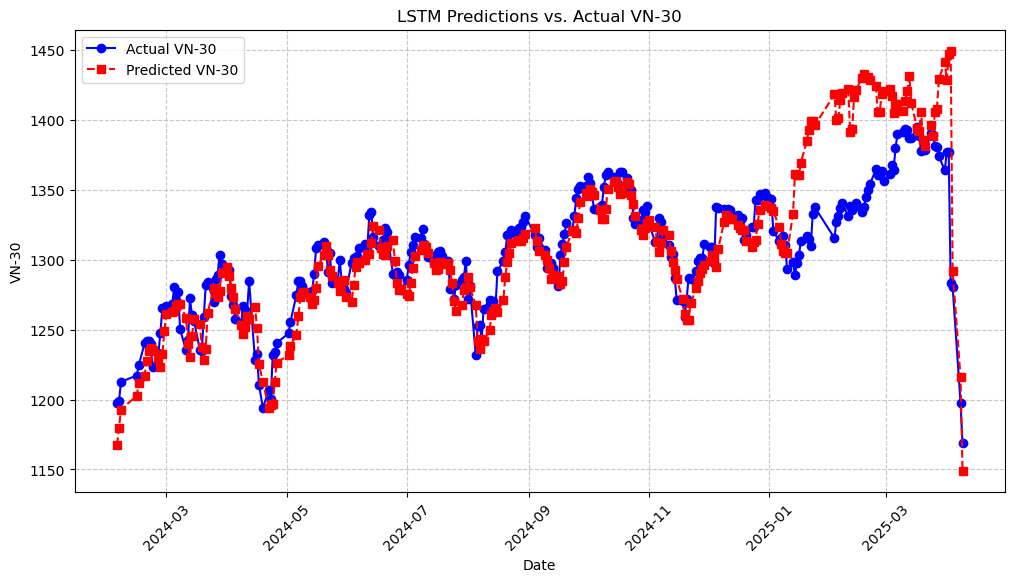

Predicted vs. Actual VN-30 (Test Set):
          Date  Actual VN-30  Predicted VN-30
0   2024-02-05   1197.360027      1167.455534
1   2024-02-06   1199.170014      1179.941749
2   2024-02-07   1212.700021      1192.851709
3   2024-02-15   1217.120030      1202.750755
4   2024-02-16   1224.540033      1211.928906
..         ...           ...              ...
285 2025-04-02   1376.940003      1446.924957
286 2025-04-03   1283.179975      1449.370631
287 2025-04-04   1280.520002      1291.699655
288 2025-04-08   1197.510016      1215.940875
289 2025-04-09   1168.679989      1149.096670

[290 rows x 3 columns]


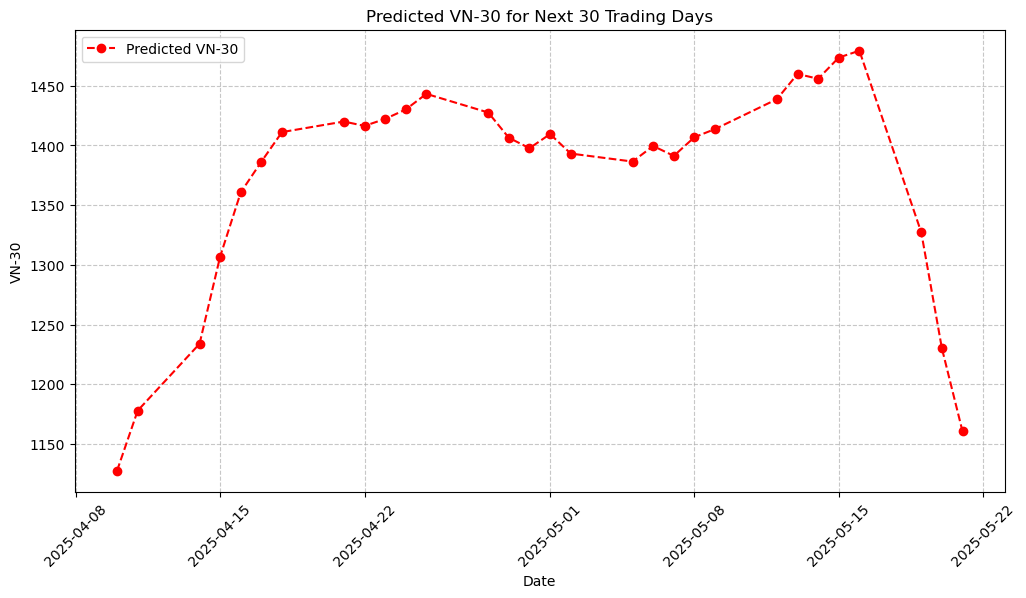

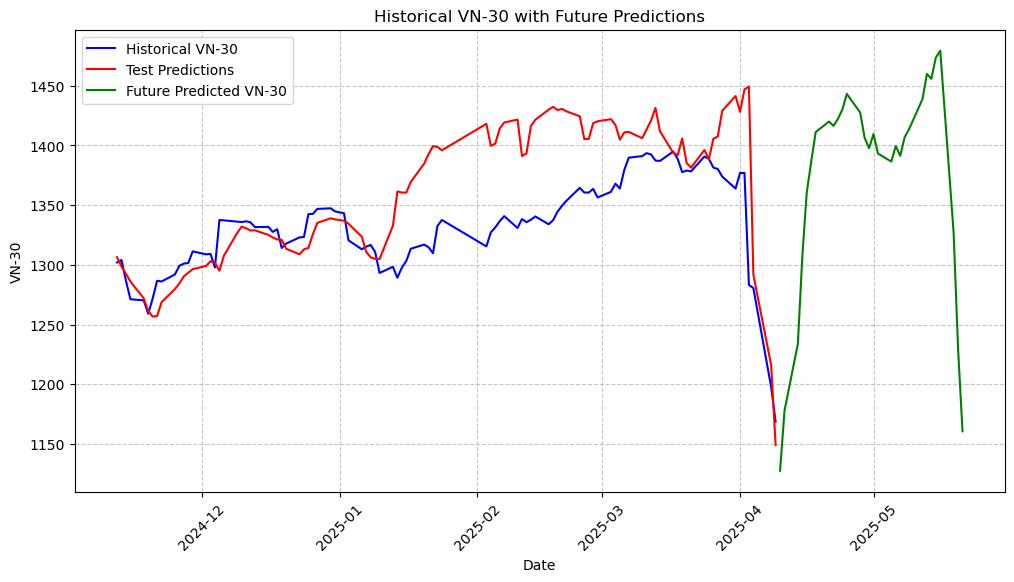

         Date  Predicted VN-30
0  2025-04-10      1127.598607
1  2025-04-11      1177.899059
2  2025-04-14      1233.867163
3  2025-04-15      1306.986193
4  2025-04-16      1360.722788
5  2025-04-17      1386.428245
6  2025-04-18      1411.176195
7  2025-04-21      1420.013247
8  2025-04-22      1416.363679
9  2025-04-23      1422.189950
10 2025-04-24      1430.114930
11 2025-04-25      1443.177104
12 2025-04-28      1427.575016
13 2025-04-29      1406.431737
14 2025-04-30      1397.671872
15 2025-05-01      1409.505614
16 2025-05-02      1393.191328
17 2025-05-05      1386.495656
18 2025-05-06      1399.522171
19 2025-05-07      1391.240654
20 2025-05-08      1406.906716
21 2025-05-09      1413.713548
22 2025-05-12      1438.743074
23 2025-05-13      1459.884802
24 2025-05-14      1455.824229
25 2025-05-15      1473.594258
26 2025-05-16      1479.313413
27 2025-05-19      1327.212478
28 2025-05-20      1230.153015
29 2025-05-21      1160.576168


In [6]:
# 📊 Select additional VN-30 statistics for prediction
data = df_1

# 🚀 Train the model and get the test set
model, X_test_tensor, scaler, y_pred = lstm_model_pipeline(data)

# 🔮 Generate future predictions
future_prediction(X_test_tensor, y_pred, data, scaler, model, num_days=30)

[I 2025-04-10 17:16:49,599] A new study created in memory with name: no-name-cf44add7-4552-4074-836f-b31963a1373b
[I 2025-04-10 17:17:20,329] Trial 0 finished with value: 0.001954747876607935 and parameters: {'hidden_size': 64, 'num_layers': 2, 'dropout': 0.2811189889183698, 'learning_rate': 0.0015849081791459423, 'batch_size': 128}. Best is trial 0 with value: 0.001954747876607935.
[I 2025-04-10 17:20:46,676] Trial 1 finished with value: 0.0007201356429512897 and parameters: {'hidden_size': 256, 'num_layers': 2, 'dropout': 0.2731665634493627, 'learning_rate': 0.006162592460104369, 'batch_size': 32}. Best is trial 1 with value: 0.0007201356429512897.
[I 2025-04-10 17:23:32,983] Trial 2 finished with value: 0.003221527292625979 and parameters: {'hidden_size': 256, 'num_layers': 2, 'dropout': 0.43561143885755915, 'learning_rate': 0.00015974294770093996, 'batch_size': 128}. Best is trial 1 with value: 0.0007201356429512897.
[I 2025-04-10 17:25:07,394] Trial 3 finished with value: 0.002267

Best Hyperparameters: {'hidden_size': 128, 'num_layers': 1, 'dropout': 0.10741835725761639, 'learning_rate': 0.00186392801716263, 'batch_size': 32}
Best Overall Average Training Loss: 0.0003
Final Evaluation Loss on Test Set: 0.0002
RMSE: 14.3030, MAE: 9.5036, R²: 0.8841, Directional Accuracy: 0.5296


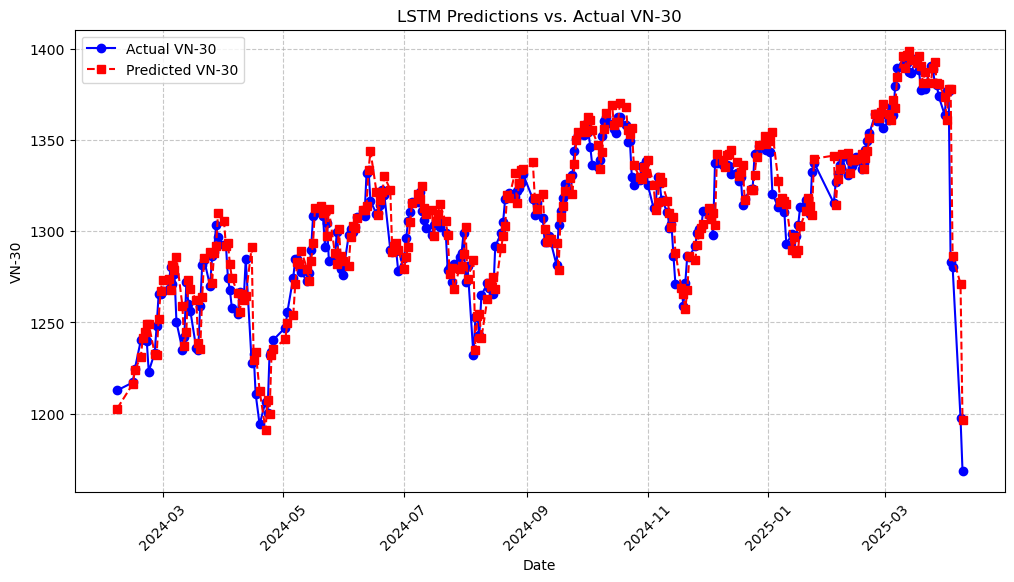

Predicted vs. Actual VN-30 (Test Set):
          Date  Actual VN-30  Predicted VN-30
0   2024-02-07   1212.700021      1202.673569
1   2024-02-15   1217.120030      1216.420236
2   2024-02-16   1224.540033      1223.960568
3   2024-02-19   1240.200028      1231.056796
4   2024-02-20   1241.649973      1241.460480
..         ...           ...              ...
283 2025-04-02   1376.940003      1378.197624
284 2025-04-03   1283.179975      1378.169311
285 2025-04-04   1280.520002      1286.644162
286 2025-04-08   1197.510016      1271.125933
287 2025-04-09   1168.679989      1196.577789

[288 rows x 3 columns]


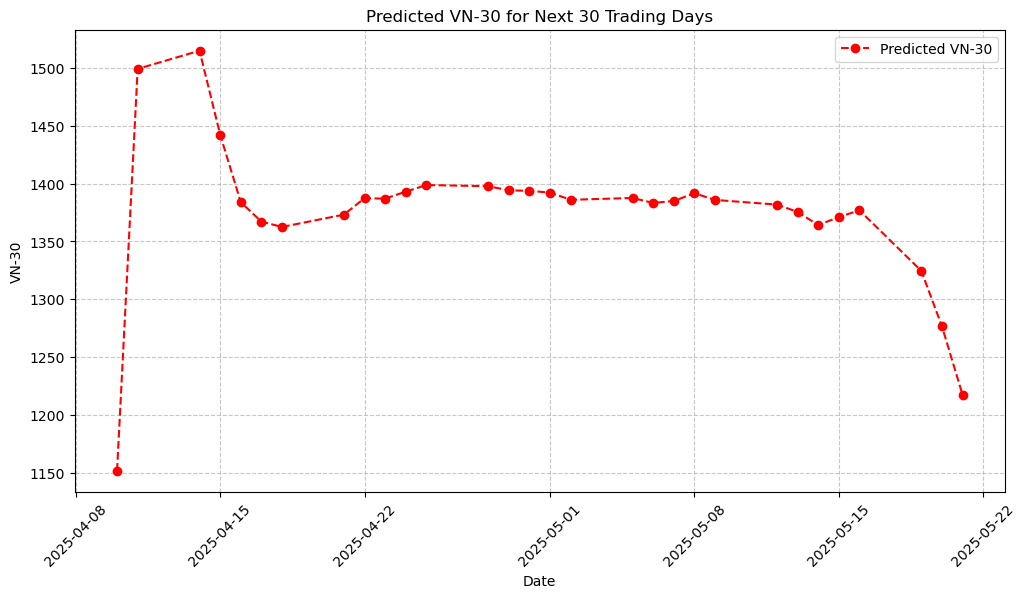

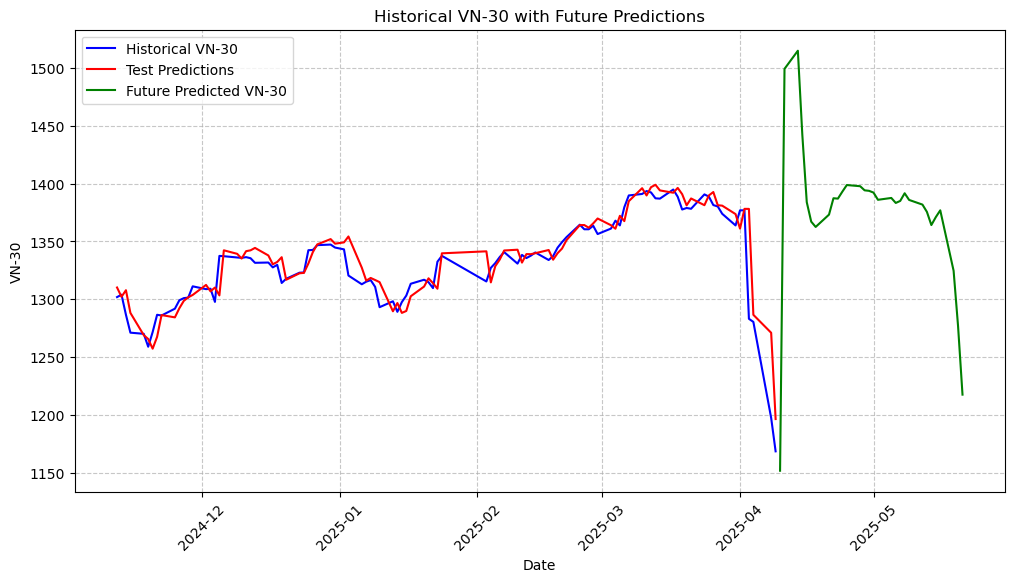

         Date  Predicted VN-30
0  2025-04-10      1151.937844
1  2025-04-11      1499.167252
2  2025-04-14      1514.832909
3  2025-04-15      1442.309389
4  2025-04-16      1383.962416
5  2025-04-17      1367.151107
6  2025-04-18      1362.580570
7  2025-04-21      1373.218980
8  2025-04-22      1387.367484
9  2025-04-23      1387.049573
10 2025-04-24      1393.078482
11 2025-04-25      1398.779098
12 2025-04-28      1397.766045
13 2025-04-29      1394.210448
14 2025-04-30      1393.772209
15 2025-05-01      1392.248382
16 2025-05-02      1386.022633
17 2025-05-05      1387.618253
18 2025-05-06      1383.305562
19 2025-05-07      1385.039914
20 2025-05-08      1391.674781
21 2025-05-09      1385.911068
22 2025-05-12      1381.880290
23 2025-05-13      1375.588344
24 2025-05-14      1364.204098
25 2025-05-15      1371.055624
26 2025-05-16      1376.937239
27 2025-05-19      1324.709370
28 2025-05-20      1276.907847
29 2025-05-21      1217.676441


In [7]:
# 📊 Select additional VN-30 statistics for prediction
data = lag_features_indicators(df_1[['VN_30_Close']], ['VN_30_Close'])

# 🚀 Train the model and get the test set
model, X_test_tensor, scaler, y_pred = lstm_model_pipeline(data)

# 🔮 Generate future predictions
future_prediction(X_test_tensor, y_pred, data, scaler, model, num_days=30)

[I 2025-04-10 17:31:22,326] A new study created in memory with name: no-name-8ce8f80b-e667-4fa8-a22c-7fcdd3faff7d
/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.39652174773107446 and num_layers=1
  warnings.warn(
[I 2025-04-10 17:33:00,213] Trial 0 finished with value: 0.0008233422677981759 and parameters: {'hidden_size': 256, 'num_layers': 1, 'dropout': 0.39652174773107446, 'learning_rate': 0.0001135575891560156, 'batch_size': 32}. Best is trial 0 with value: 0.0008233422677981759.
[I 2025-04-10 17:33:45,053] Trial 1 finished with value: 0.0008854293722284234 and parameters: {'hidden_size': 64, 'num_layers': 2, 'dropout': 0.2716850482376289, 'learning_rate': 0.0030636327640200275, 'batch_size': 64}. Best is trial 0 with value: 0.0008233422677981759.
[I 2025-04-10 17:38:48,637] Trial 2 finished with value: 0.0008

Best Hyperparameters: {'hidden_size': 256, 'num_layers': 3, 'dropout': 0.10673313279158725, 'learning_rate': 0.0009586284472341839, 'batch_size': 32}
Best Overall Average Training Loss: 0.0008
Final Evaluation Loss on Test Set: 0.0027
RMSE: 58.2509, MAE: 40.8279, R²: -0.9224, Directional Accuracy: 0.5679


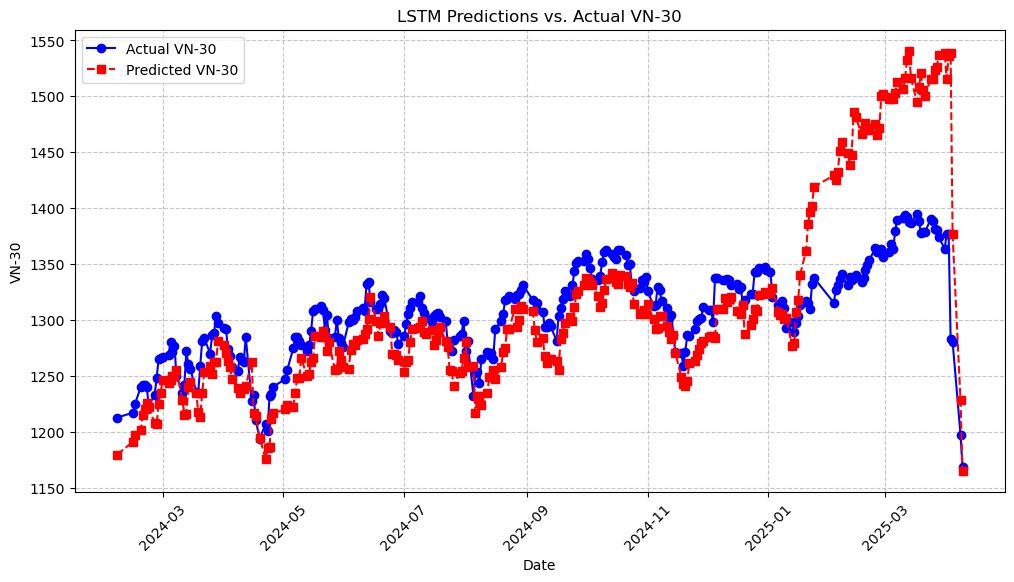

Predicted vs. Actual VN-30 (Test Set):
          Date  Actual VN-30  Predicted VN-30
0   2024-02-07   1212.700021      1179.689968
1   2024-02-15   1217.120030      1191.028644
2   2024-02-16   1224.540033      1197.336500
3   2024-02-19   1240.200028      1201.314225
4   2024-02-20   1241.649973      1215.158974
..         ...           ...              ...
283 2025-04-02   1376.940003      1536.296525
284 2025-04-03   1283.179975      1538.455297
285 2025-04-04   1280.520002      1376.676561
286 2025-04-08   1197.510016      1228.047498
287 2025-04-09   1168.679989      1165.223149

[288 rows x 3 columns]


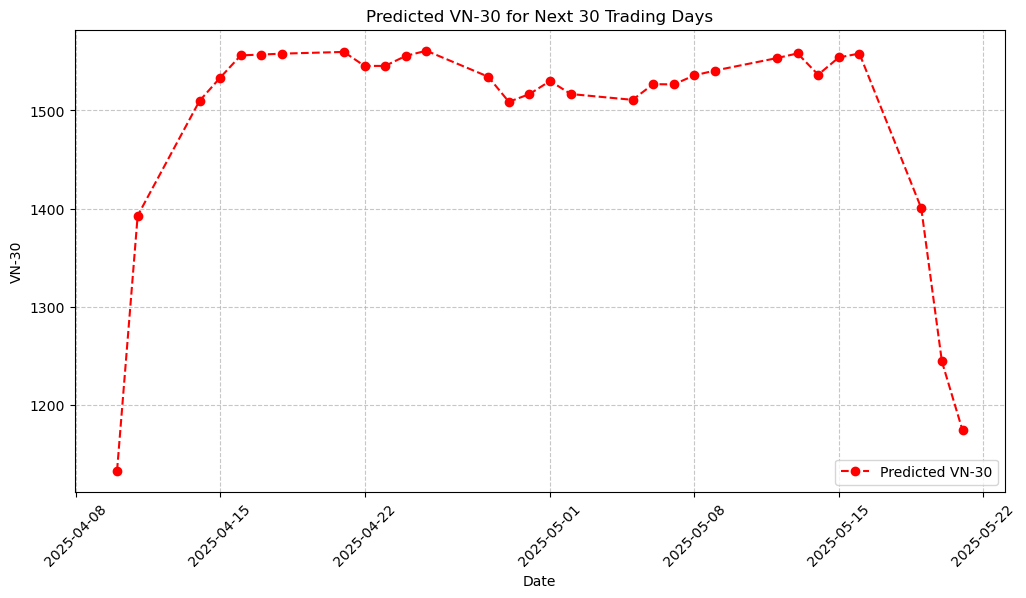

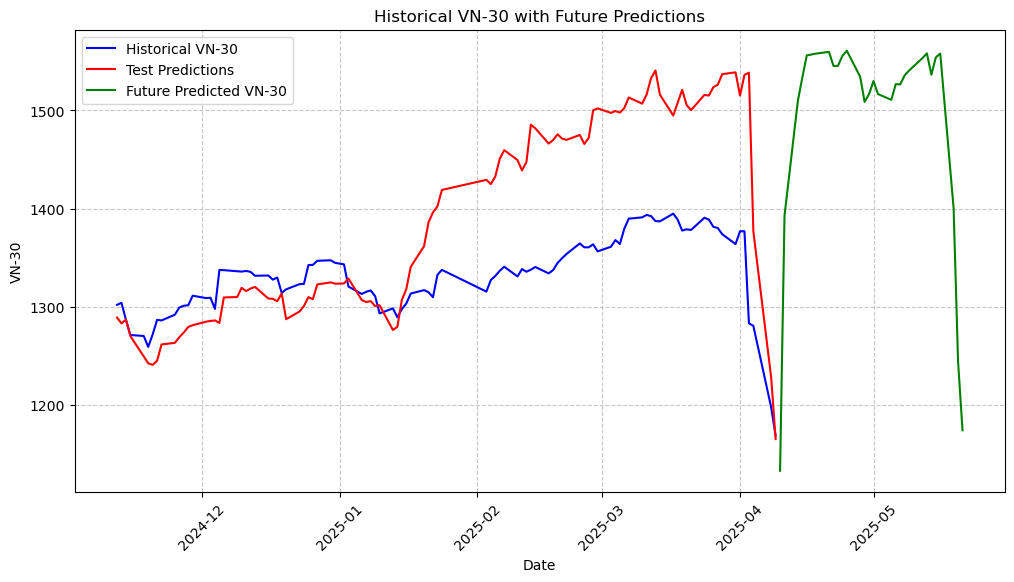

         Date  Predicted VN-30
0  2025-04-10      1132.940125
1  2025-04-11      1392.810995
2  2025-04-14      1509.770541
3  2025-04-15      1533.415107
4  2025-04-16      1556.124681
5  2025-04-17      1556.971634
6  2025-04-18      1557.900828
7  2025-04-21      1559.664841
8  2025-04-22      1545.408344
9  2025-04-23      1545.396615
10 2025-04-24      1555.592134
11 2025-04-25      1560.877296
12 2025-04-28      1534.401061
13 2025-04-29      1508.808450
14 2025-04-30      1516.692983
15 2025-05-01      1530.071248
16 2025-05-02      1516.745024
17 2025-05-05      1510.841433
18 2025-05-06      1526.829989
19 2025-05-07      1526.574097
20 2025-05-08      1535.784740
21 2025-05-09      1540.709793
22 2025-05-12      1553.365681
23 2025-05-13      1558.142159
24 2025-05-14      1536.429595
25 2025-05-15      1554.010940
26 2025-05-16      1558.009225
27 2025-05-19      1400.424131
28 2025-05-20      1244.308463
29 2025-05-21      1174.117231


In [8]:
# 📊 Select additional VN-30 statistics for prediction
data = lag_features_indicators(df_1, ['VN_30_Close'])

# 🚀 Train the model and get the test set
model, X_test_tensor, scaler, y_pred = lstm_model_pipeline(data)

# 🔮 Generate future predictions
future_prediction(X_test_tensor, y_pred, data, scaler, model, num_days=30)

[I 2025-04-10 17:49:14,962] A new study created in memory with name: no-name-b2a5be7e-074e-45ee-8e53-edc8209ac00b
[I 2025-04-10 17:50:56,205] Trial 0 finished with value: 0.0005685903460002414 and parameters: {'hidden_size': 64, 'num_layers': 3, 'dropout': 0.18340483390307424, 'learning_rate': 0.003601069805130784, 'batch_size': 32}. Best is trial 0 with value: 0.0005685903460002414.
/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3905667925301751 and num_layers=1
  warnings.warn(
[I 2025-04-10 17:52:34,823] Trial 1 finished with value: 0.001413541283693323 and parameters: {'hidden_size': 256, 'num_layers': 1, 'dropout': 0.3905667925301751, 'learning_rate': 0.0072155827596875975, 'batch_size': 32}. Best is trial 0 with value: 0.0005685903460002414.
[I 2025-04-10 17:55:29,867] Trial 2 finished with value: 0.0006541

Best Hyperparameters: {'hidden_size': 64, 'num_layers': 1, 'dropout': 0.44939873295742466, 'learning_rate': 0.0010537104852809797, 'batch_size': 64}
Best Overall Average Training Loss: 0.0004
Final Evaluation Loss on Test Set: 0.0916
RMSE: 271.0409, MAE: 123.9494, R²: -40.6210, Directional Accuracy: 0.5575


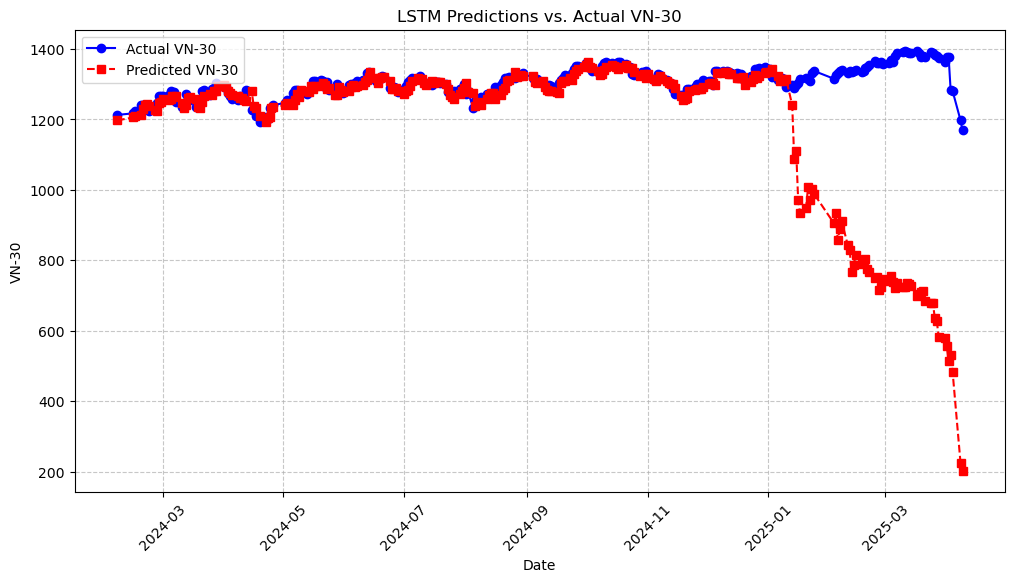

Predicted vs. Actual VN-30 (Test Set):
          Date  Actual VN-30  Predicted VN-30
0   2024-02-07   1212.700021      1197.086877
1   2024-02-15   1217.120030      1205.478408
2   2024-02-16   1224.540033      1209.159592
3   2024-02-19   1240.200028      1213.071995
4   2024-02-20   1241.649973      1229.155467
..         ...           ...              ...
283 2025-04-02   1376.940003       514.100194
284 2025-04-03   1283.179975       532.375671
285 2025-04-04   1280.520002       483.809133
286 2025-04-08   1197.510016       225.343936
287 2025-04-09   1168.679989       203.118205

[288 rows x 3 columns]


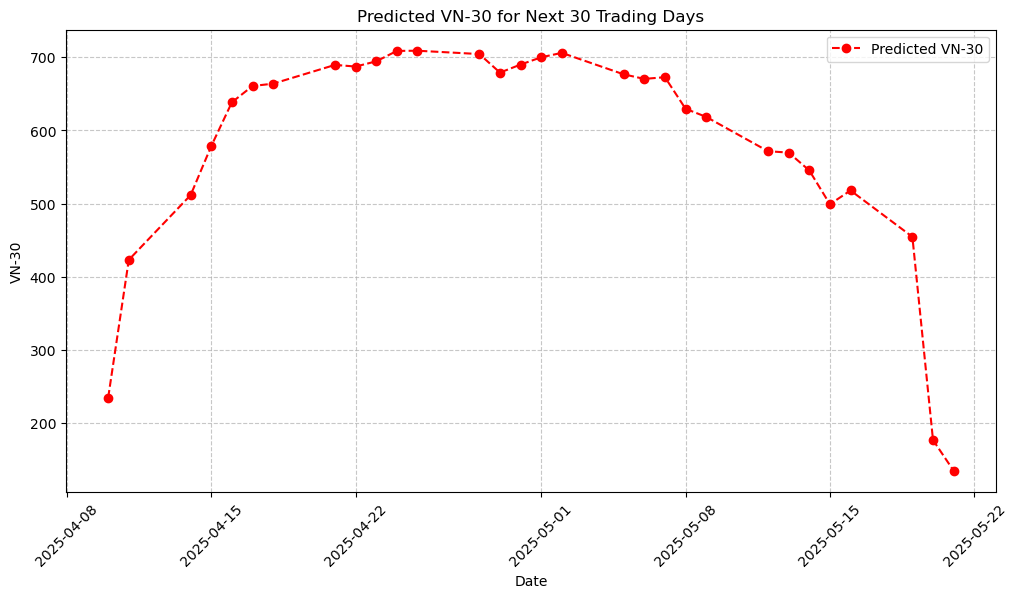

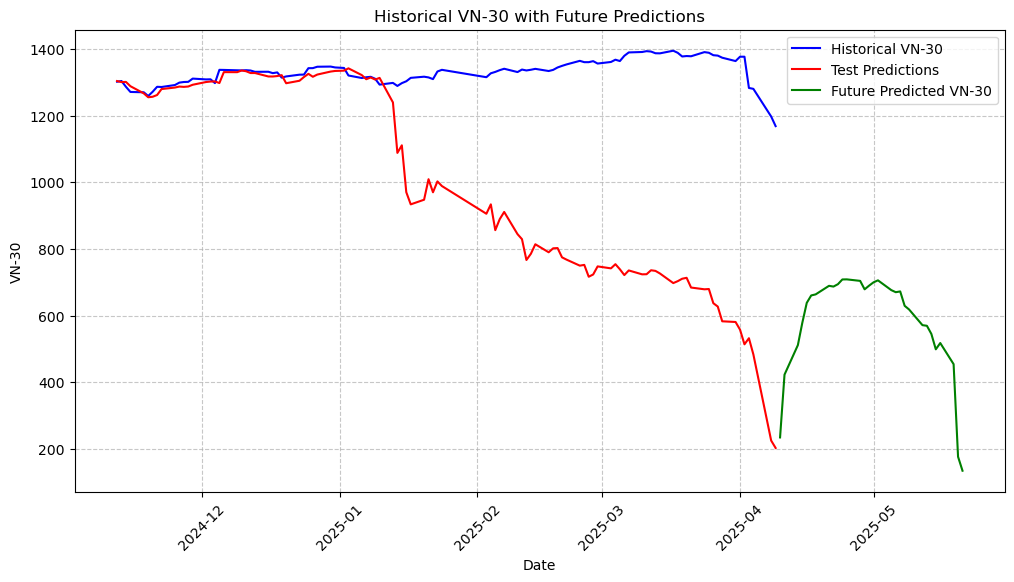

         Date  Predicted VN-30
0  2025-04-10       234.740533
1  2025-04-11       423.101424
2  2025-04-14       511.636589
3  2025-04-15       578.650334
4  2025-04-16       638.494456
5  2025-04-17       660.721940
6  2025-04-18       663.907619
7  2025-04-21       689.574264
8  2025-04-22       687.318791
9  2025-04-23       694.454387
10 2025-04-24       708.701749
11 2025-04-25       708.951372
12 2025-04-28       704.398766
13 2025-04-29       679.052677
14 2025-04-30       690.031446
15 2025-05-01       700.007205
16 2025-05-02       706.014912
17 2025-05-05       676.670101
18 2025-05-06       670.454463
19 2025-05-07       672.764236
20 2025-05-08       629.602330
21 2025-05-09       618.511474
22 2025-05-12       571.581441
23 2025-05-13       569.709233
24 2025-05-14       545.308720
25 2025-05-15       499.107029
26 2025-05-16       517.947074
27 2025-05-19       454.568016
28 2025-05-20       176.756315
29 2025-05-21       134.863827


In [9]:
# 📊 Select additional VN-30 statistics for prediction
data = lag_features_indicators(df_1, df_1.columns)

# 🚀 Train the model and get the test set
model, X_test_tensor, scaler, y_pred = lstm_model_pipeline(data)

# 🔮 Generate future predictions
future_prediction(X_test_tensor, y_pred, data, scaler, model, num_days=30)

In [10]:
# 📂 Load dataset
file_path_2 = "../ready_data/vn_30_merged_data.csv"
df_2 = pd.read_csv(file_path_2)
df_2 = quicky_data(df_2)

[I 2025-04-10 18:01:48,908] A new study created in memory with name: no-name-bb4502e9-74a4-46b0-91ef-715b1e890712
[I 2025-04-10 18:03:46,420] Trial 0 finished with value: 0.0010129165706392893 and parameters: {'hidden_size': 128, 'num_layers': 3, 'dropout': 0.4834552576482491, 'learning_rate': 0.0012935826370797689, 'batch_size': 64}. Best is trial 0 with value: 0.0010129165706392893.
/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.20040697592471968 and num_layers=1
  warnings.warn(
[I 2025-04-10 18:04:17,223] Trial 1 finished with value: 0.0014158425666455116 and parameters: {'hidden_size': 128, 'num_layers': 1, 'dropout': 0.20040697592471968, 'learning_rate': 0.0006049106595206865, 'batch_size': 128}. Best is trial 0 with value: 0.0010129165706392893.
[I 2025-04-10 18:05:49,563] Trial 2 finished with value: 0.00

Best Hyperparameters: {'hidden_size': 256, 'num_layers': 1, 'dropout': 0.3493223293911448, 'learning_rate': 0.004468456610193804, 'batch_size': 32}
Best Overall Average Training Loss: 0.0003
Final Evaluation Loss on Test Set: 0.0455
RMSE: 172.2767, MAE: 84.3098, R²: -15.1924, Directional Accuracy: 0.5363


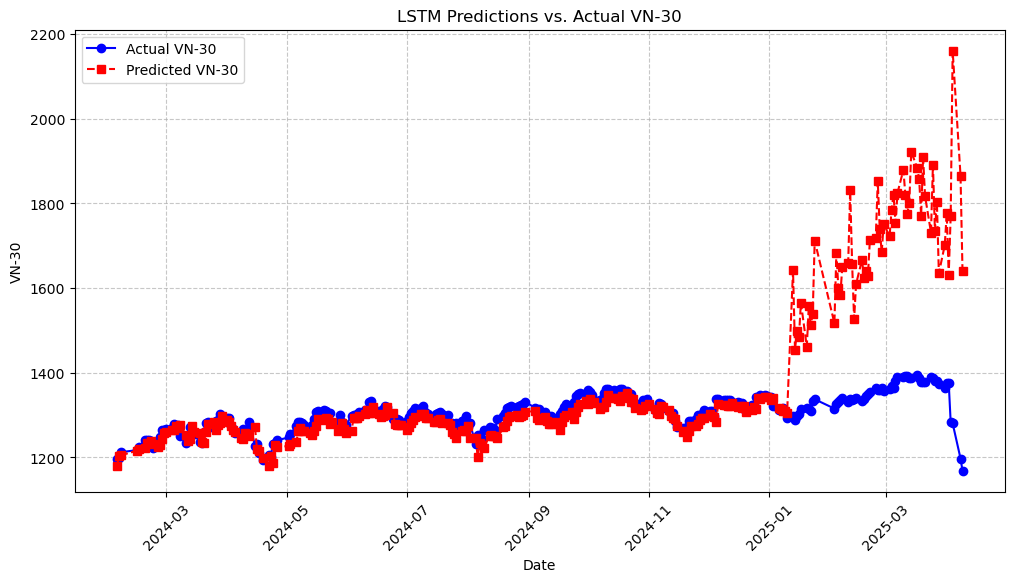

Predicted vs. Actual VN-30 (Test Set):
          Date  Actual VN-30  Predicted VN-30
0   2024-02-05   1197.360027      1180.793353
1   2024-02-06   1199.170014      1202.591395
2   2024-02-07   1212.700021      1205.073470
3   2024-02-15   1217.120030      1215.988805
4   2024-02-16   1224.540033      1219.351673
..         ...           ...              ...
285 2025-04-02   1376.940003      1631.419335
286 2025-04-03   1283.179975      1770.035630
287 2025-04-04   1280.520002      2160.920578
288 2025-04-08   1197.510016      1865.324811
289 2025-04-09   1168.679989      1639.492215

[290 rows x 3 columns]


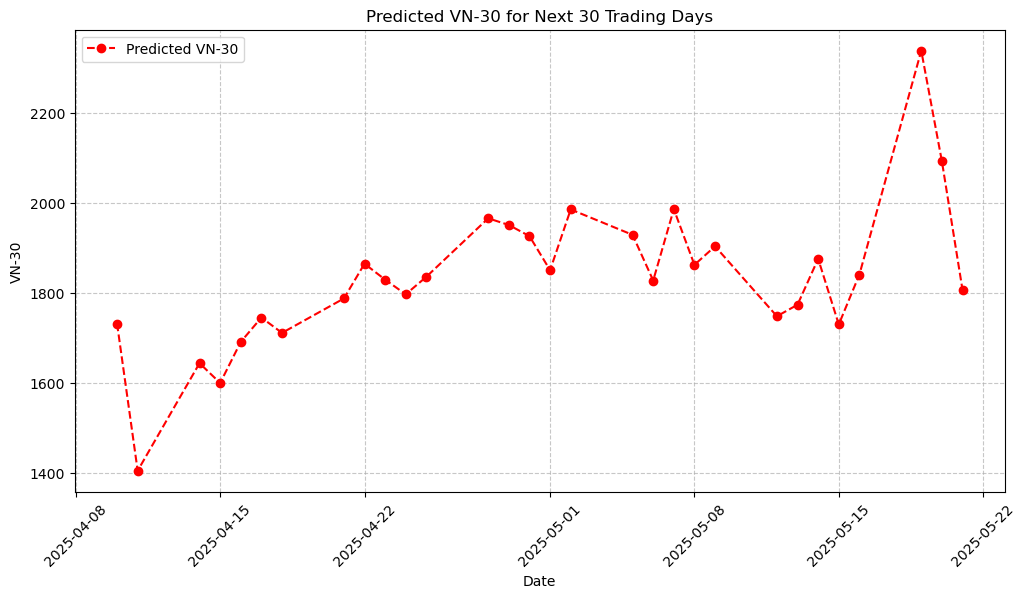

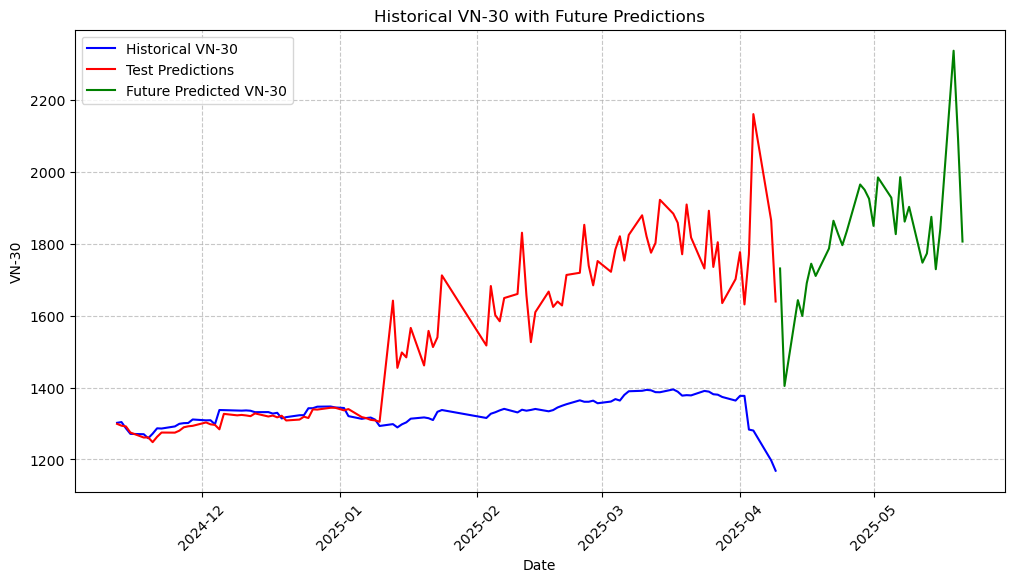

         Date  Predicted VN-30
0  2025-04-10      1731.398978
1  2025-04-11      1404.496029
2  2025-04-14      1643.309029
3  2025-04-15      1599.248888
4  2025-04-16      1690.581578
5  2025-04-17      1744.696485
6  2025-04-18      1710.602664
7  2025-04-21      1787.014050
8  2025-04-22      1864.209562
9  2025-04-23      1828.883602
10 2025-04-24      1796.224424
11 2025-04-25      1835.256779
12 2025-04-28      1965.092783
13 2025-04-29      1950.247922
14 2025-04-30      1925.482715
15 2025-05-01      1849.860173
16 2025-05-02      1984.795284
17 2025-05-05      1928.385975
18 2025-05-06      1826.927198
19 2025-05-07      1985.517122
20 2025-05-08      1861.773326
21 2025-05-09      1902.896233
22 2025-05-12      1747.563073
23 2025-05-13      1773.166874
24 2025-05-14      1875.133390
25 2025-05-15      1729.322178
26 2025-05-16      1840.164574
27 2025-05-19      2337.289766
28 2025-05-20      2091.912276
29 2025-05-21      1806.370059


In [11]:
data = df_2

# 🚀 Train the model and get the test set
model, X_test_tensor, scaler, y_pred = lstm_model_pipeline(data)

# 🔮 Generate future predictions
future_prediction(X_test_tensor, y_pred, data, scaler, model, num_days=30)

[I 2025-04-10 18:21:20,853] A new study created in memory with name: no-name-b0325fe7-e8dc-41b4-aba8-81f978fa0f13
/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3026550490908263 and num_layers=1
  warnings.warn(
[I 2025-04-10 18:21:43,263] Trial 0 finished with value: 0.0005761179545564421 and parameters: {'hidden_size': 64, 'num_layers': 1, 'dropout': 0.3026550490908263, 'learning_rate': 0.0019024389404634376, 'batch_size': 64}. Best is trial 0 with value: 0.0005761179545564421.
/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.46156913731803517 and num_layers=1
  warnings.warn(
[I 2025-04-10 18:22:20,900] Trial 1 finished with value: 0.00046

Best Hyperparameters: {'hidden_size': 128, 'num_layers': 1, 'dropout': 0.46156913731803517, 'learning_rate': 0.000938461250283593, 'batch_size': 64}
Best Overall Average Training Loss: 0.0005
Final Evaluation Loss on Test Set: 0.0116
RMSE: 92.6491, MAE: 42.8001, R²: -3.8632, Directional Accuracy: 0.5470


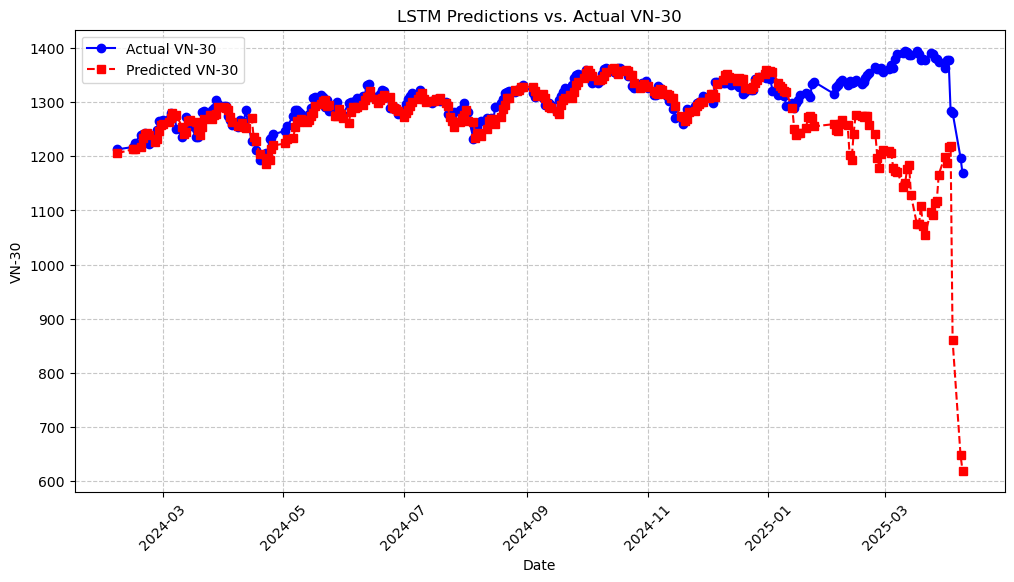

Predicted vs. Actual VN-30 (Test Set):
          Date  Actual VN-30  Predicted VN-30
0   2024-02-07   1212.700021      1205.411537
1   2024-02-15   1217.120030      1213.035661
2   2024-02-16   1224.540033      1214.259846
3   2024-02-19   1240.200028      1217.578358
4   2024-02-20   1241.649973      1233.920485
..         ...           ...              ...
283 2025-04-02   1376.940003      1217.306691
284 2025-04-03   1283.179975      1219.593679
285 2025-04-04   1280.520002       860.020900
286 2025-04-08   1197.510016       648.493371
287 2025-04-09   1168.679989       619.420799

[288 rows x 3 columns]


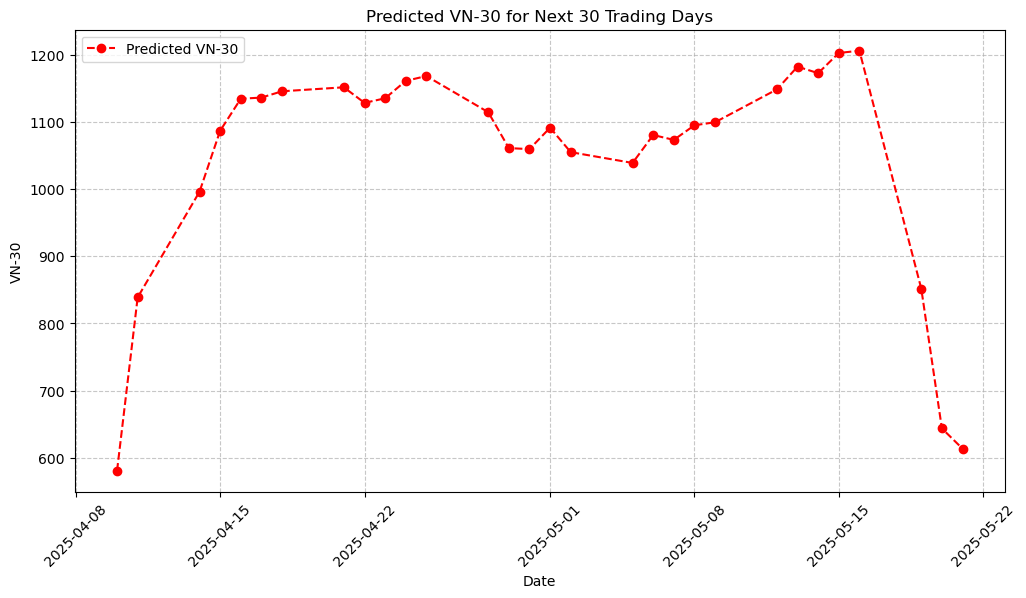

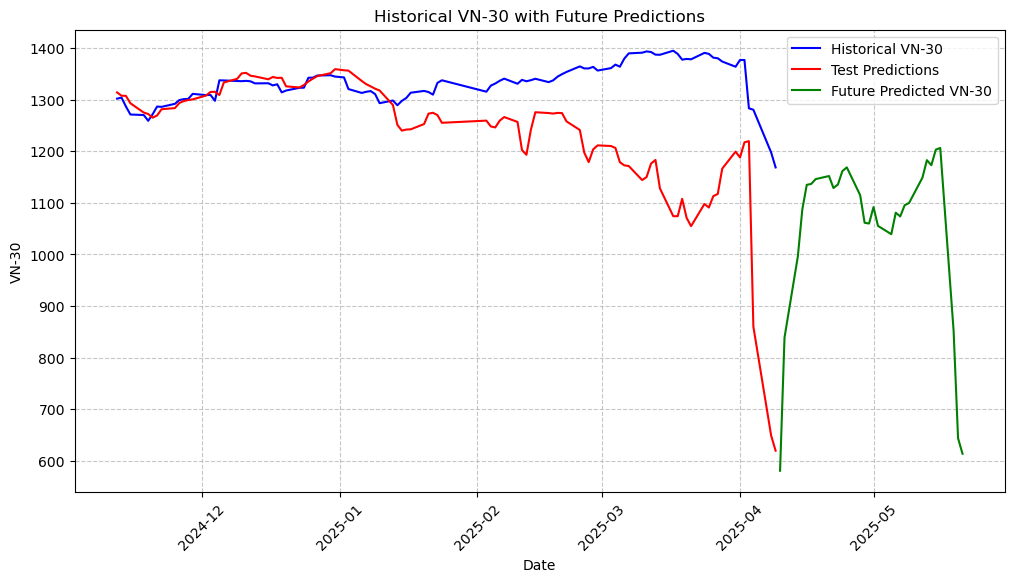

         Date  Predicted VN-30
0  2025-04-10       580.606552
1  2025-04-11       838.927034
2  2025-04-14       996.347410
3  2025-04-15      1087.231648
4  2025-04-16      1134.894642
5  2025-04-17      1136.626162
6  2025-04-18      1146.010794
7  2025-04-21      1151.960966
8  2025-04-22      1128.764819
9  2025-04-23      1135.541788
10 2025-04-24      1161.495924
11 2025-04-25      1168.746928
12 2025-04-28      1114.881645
13 2025-04-29      1061.346608
14 2025-04-30      1059.846577
15 2025-05-01      1091.751290
16 2025-05-02      1055.303678
17 2025-05-05      1039.230925
18 2025-05-06      1080.849977
19 2025-05-07      1073.583739
20 2025-05-08      1095.361220
21 2025-05-09      1099.850393
22 2025-05-12      1148.847114
23 2025-05-13      1182.737623
24 2025-05-14      1172.986612
25 2025-05-15      1203.099539
26 2025-05-16      1206.451083
27 2025-05-19       851.969761
28 2025-05-20       643.638274
29 2025-05-21       613.532611


In [12]:
data = lag_features_indicators(df_2, ['VN_30_Close'])

# 🚀 Train the model and get the test set
model, X_test_tensor, scaler, y_pred = lstm_model_pipeline(data)

# 🔮 Generate future predictions
future_prediction(X_test_tensor, y_pred, data, scaler, model, num_days=30)

[I 2025-04-10 18:41:59,464] A new study created in memory with name: no-name-9346c3e7-c025-47a0-aad7-b5e65710b168
[I 2025-04-10 18:46:17,504] Trial 0 finished with value: 0.0010337712442876933 and parameters: {'hidden_size': 256, 'num_layers': 3, 'dropout': 0.2867416162594753, 'learning_rate': 0.0009201871670717341, 'batch_size': 128}. Best is trial 0 with value: 0.0010337712442876933.
/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4541294119244493 and num_layers=1
  warnings.warn(
[I 2025-04-10 18:47:10,734] Trial 1 finished with value: 0.0005935934418767931 and parameters: {'hidden_size': 128, 'num_layers': 1, 'dropout': 0.4541294119244493, 'learning_rate': 0.0001105584312802438, 'batch_size': 32}. Best is trial 1 with value: 0.0005935934418767931.
[I 2025-04-10 18:49:04,747] Trial 2 finished with value: 0.0015

Best Hyperparameters: {'hidden_size': 64, 'num_layers': 1, 'dropout': 0.27063022730157077, 'learning_rate': 0.006785929135028381, 'batch_size': 32}
Best Overall Average Training Loss: 0.0004
Final Evaluation Loss on Test Set: 0.1049
RMSE: 366.3729, MAE: 173.2727, R²: -75.0483, Directional Accuracy: 0.5157


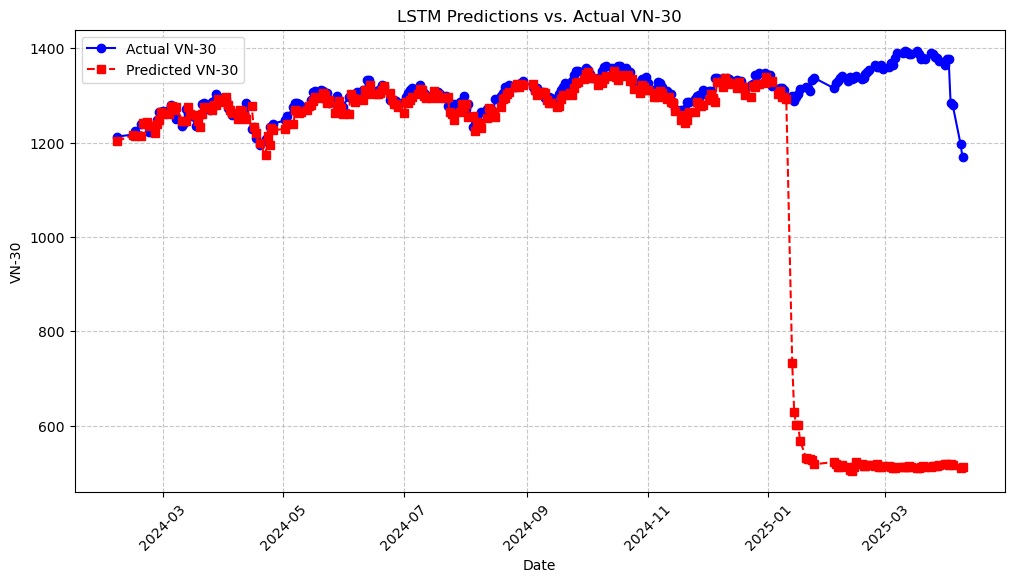

Predicted vs. Actual VN-30 (Test Set):
          Date  Actual VN-30  Predicted VN-30
0   2024-02-07   1212.700021      1203.105135
1   2024-02-15   1217.120030      1215.961975
2   2024-02-16   1224.540033      1213.460350
3   2024-02-19   1240.200028      1214.850839
4   2024-02-20   1241.649973      1241.505308
..         ...           ...              ...
283 2025-04-02   1376.940003       516.852638
284 2025-04-03   1283.179975       518.192930
285 2025-04-04   1280.520002       517.251838
286 2025-04-08   1197.510016       510.876403
287 2025-04-09   1168.679989       511.049043

[288 rows x 3 columns]


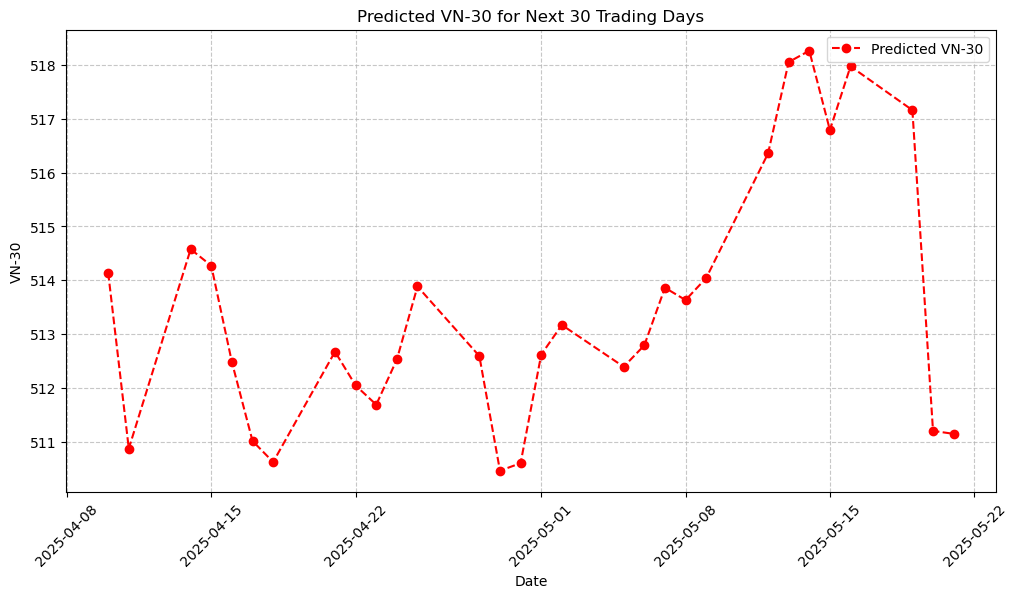

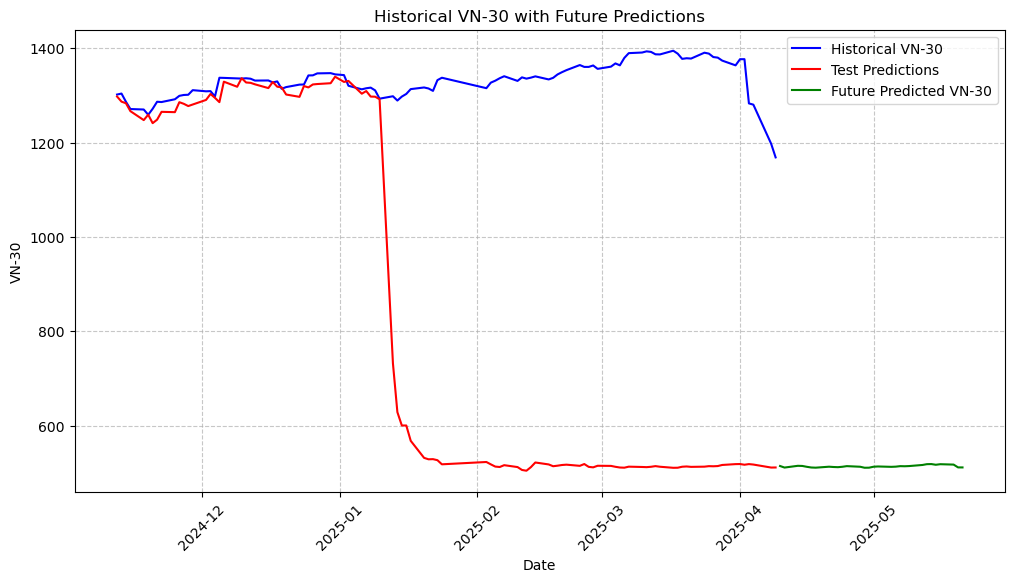

         Date  Predicted VN-30
0  2025-04-10       514.139427
1  2025-04-11       510.870505
2  2025-04-14       514.576723
3  2025-04-15       514.269952
4  2025-04-16       512.477416
5  2025-04-17       511.012599
6  2025-04-18       510.620553
7  2025-04-21       512.671433
8  2025-04-22       512.043693
9  2025-04-23       511.686794
10 2025-04-24       512.526938
11 2025-04-25       513.883838
12 2025-04-28       512.590287
13 2025-04-29       510.459457
14 2025-04-30       510.599639
15 2025-05-01       512.617488
16 2025-05-02       513.168860
17 2025-05-05       512.391416
18 2025-05-06       512.790405
19 2025-05-07       513.860236
20 2025-05-08       513.631468
21 2025-05-09       514.040493
22 2025-05-12       516.355524
23 2025-05-13       518.054443
24 2025-05-14       518.265305
25 2025-05-15       516.791320
26 2025-05-16       517.975479
27 2025-05-19       517.161019
28 2025-05-20       511.200002
29 2025-05-21       511.144729


In [13]:
data = lag_features_indicators(df_2, df_1.columns)

# 🚀 Train the model and get the test set
model, X_test_tensor, scaler, y_pred = lstm_model_pipeline(data)

# 🔮 Generate future predictions
future_prediction(X_test_tensor, y_pred, data, scaler, model, num_days=30)

/var/folders/fl/t1q3j3rn0dg278fhg2bvg0dw0000gn/T/ipykernel_13815/1678451533.py:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  copy_df[f'{col}_Lag{lag}'] = copy_df[col].shift(lag)
/var/folders/fl/t1q3j3rn0dg278fhg2bvg0dw0000gn/T/ipykernel_13815/1678451533.py:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  copy_df[f'{col}_Lag{lag}'] = copy_df[col].shift(lag)
/var/folders/fl/t1q3j3rn0dg278fhg2bvg0dw0000gn/T/ipykernel_13815/1678451533.py:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

Best Hyperparameters: {'hidden_size': 128, 'num_layers': 1, 'dropout': 0.417086682580886, 'learning_rate': 0.0006766899859219644, 'batch_size': 32}
Best Overall Average Training Loss: 0.0004
Final Evaluation Loss on Test Set: 0.0280
RMSE: 189.1306, MAE: 100.4731, R²: -19.2659, Directional Accuracy: 0.5122


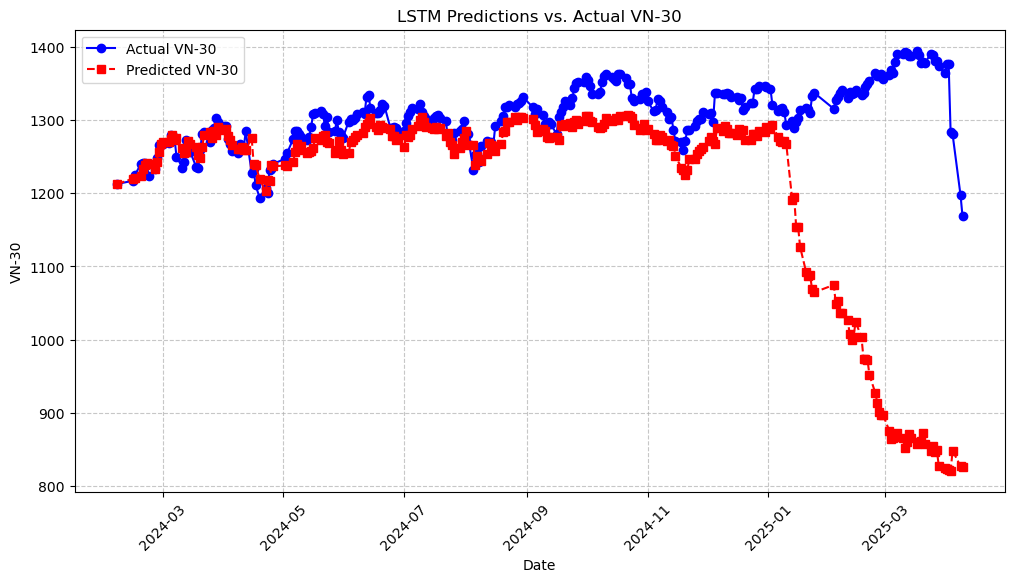

Predicted vs. Actual VN-30 (Test Set):
          Date  Actual VN-30  Predicted VN-30
0   2024-02-07   1212.700021      1212.427478
1   2024-02-15   1217.120030      1220.014256
2   2024-02-16   1224.540033      1220.543096
3   2024-02-19   1240.200028      1223.190059
4   2024-02-20   1241.649973      1232.793237
..         ...           ...              ...
283 2025-04-02   1376.940003       821.147231
284 2025-04-03   1283.179975       820.718362
285 2025-04-04   1280.520002       848.227469
286 2025-04-08   1197.510016       826.683533
287 2025-04-09   1168.679989       825.660739

[288 rows x 3 columns]


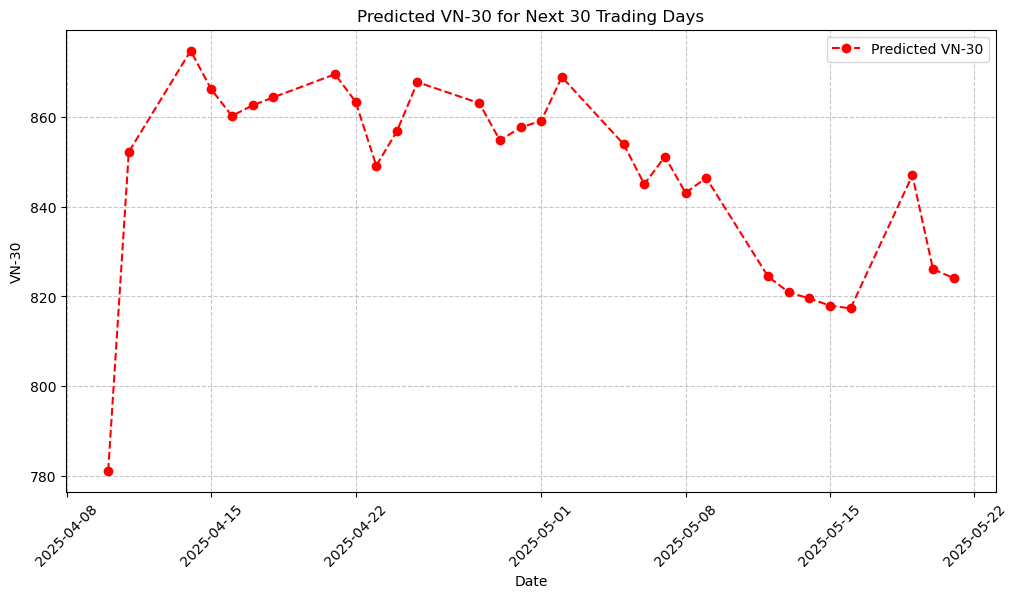

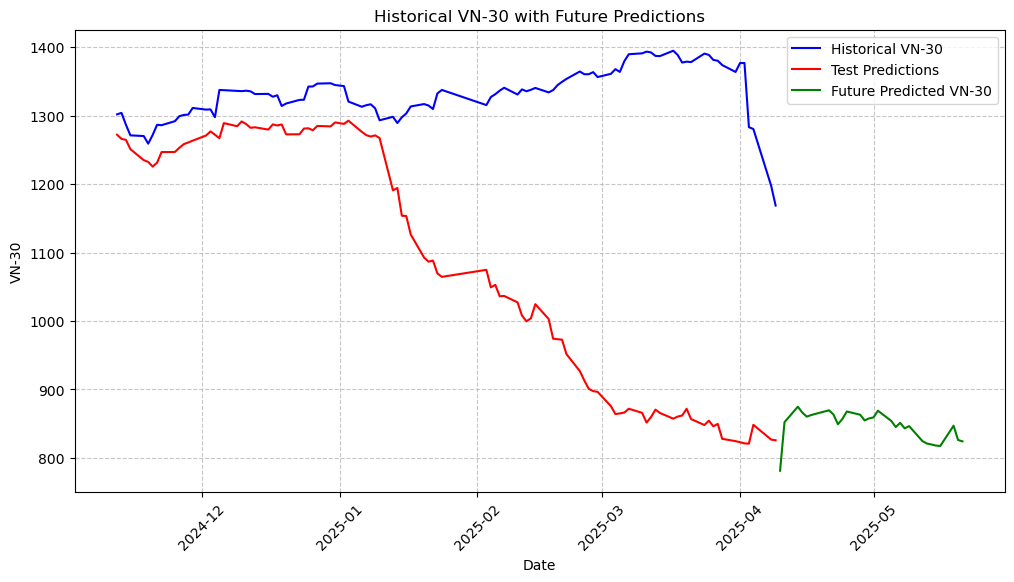

         Date  Predicted VN-30
0  2025-04-10       781.188379
1  2025-04-11       852.182645
2  2025-04-14       874.723726
3  2025-04-15       866.117490
4  2025-04-16       860.198866
5  2025-04-17       862.548782
6  2025-04-18       864.327861
7  2025-04-21       869.482246
8  2025-04-22       863.358827
9  2025-04-23       849.129868
10 2025-04-24       856.785911
11 2025-04-25       867.721401
12 2025-04-28       863.033366
13 2025-04-29       854.737558
14 2025-04-30       857.644054
15 2025-05-01       859.102020
16 2025-05-02       868.870153
17 2025-05-05       853.886965
18 2025-05-06       845.003198
19 2025-05-07       851.132280
20 2025-05-08       843.086668
21 2025-05-09       846.391293
22 2025-05-12       824.446531
23 2025-05-13       820.934954
24 2025-05-14       819.549184
25 2025-05-15       817.974192
26 2025-05-16       817.322428
27 2025-05-19       846.981578
28 2025-05-20       826.087721
29 2025-05-21       824.073377


In [14]:
data = lag_features_indicators(df_2, df_2.columns)

# 🚀 Train the model and get the test set
model, X_test_tensor, scaler, y_pred = lstm_model_pipeline(data)

# 🔮 Generate future predictions
future_prediction(X_test_tensor, y_pred, data, scaler, model, num_days=30)

In [15]:
# # 📂 Load dataset
# file_path_3 = "../ready_data/merged_data.csv"
# df_3 = pd.read_csv(file_path_3)
# df_3 = quicky_data(df_3)

In [16]:
# data = df_3

# # 🚀 Train the model and get the test set
# model, X_test_tensor, scaler, y_pred = lstm_model_pipeline(data)

# # 🔮 Generate future predictions
# future_prediction(X_test_tensor, y_pred, data, scaler, model, num_days=30)

In [17]:
# data = lag_features_indicators(df_3, ['VN_30_Close'])

# # 🚀 Train the model and get the test set
# model, X_test_tensor, scaler, y_pred = lstm_model_pipeline(data)

# # 🔮 Generate future predictions
# future_prediction(X_test_tensor, y_pred, data, scaler, model, num_days=30)

In [18]:
# data = lag_features_indicators(df_3, df_3.columns)

# # 🚀 Train the model and get the test set
# model, X_test_tensor, scaler, y_pred = lstm_model_pipeline(data)

# # 🔮 Generate future predictions
# future_prediction(X_test_tensor, y_pred, data, scaler, model, num_days=30)

In [19]:
# data = lag_features_indicators(df_3, df_1.columns)

# # 🚀 Train the model and get the test set
# model, X_test_tensor, scaler, y_pred = lstm_model_pipeline(data)

# # 🔮 Generate future predictions
# future_prediction(X_test_tensor, y_pred, data, scaler, model, num_days=30)

In [20]:
# data = lag_features_indicators(df_3, df_2.columns)

# # 🚀 Train the model and get the test set
# model, X_test_tensor, scaler, y_pred = lstm_model_pipeline(data)

# # 🔮 Generate future predictions
# future_prediction(X_test_tensor, y_pred, data, scaler, model, num_days=30)